<a href="https://colab.research.google.com/github/Koelgeetkaur26/Spiking-Temporal-Memory-STM-Network-Implementation/blob/main/STM_implementation_2023_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **Introduction-** This notebook shows an end-to-end implementation of the 2023 paper from Neuromorphic Computing and Engineering (Bouhadjar et al., 2023).

**Note on Model Scope (A "Toy Model" for Clarity):**

This notebook implements a simplified "toy model" to clearly demonstrate the paper's core mechanisms.

The Paper: Simulates a large, 12-club network (A-L) learning four complex, overlapping sequences (e.g., A->D->B... and F->D->B...).

This Notebook: Simulates a smaller, 3-club network (A-B-C) learning one simple, linear sequence (A->B->C).

This simplification is deliberate. It allows us to isolate and clearly visualize the STDP learning rule and synapse behavior (the "flowchart" logic) in action, without the added complexity of the full-scale network. The underlying principles and code logic for the neuron and synapse models are a faithful implementation of the paper's design.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class BinarySynapse:
    """
    Implements the Binary Synapse Model (Eq. 2 & 3 from the paper).
    This object acts as our "hardware" component.
    """

    def __init__(self, P_max=20.0, P_thresh=10.0, G_min=1e-9, G_max=100e-6,
                 lambda_plus=0.1, lambda_minus=0.05, mu_plus=0.5, mu_minus=0.5):

        # --- Model Parameters (from paper) ---
        self.P_max = P_max          # Max permanence (internal memory)
        self.P_thresh = P_thresh    # Permanence threshold for switching ON
        self.G_min = G_min          # Min conductance (OFF state strength)
        self.G_max = G_max          # Max conductance (ON state strength)

        # --- Learning Rate Parameters (from paper) ---
        self.lambda_plus = lambda_plus     # Potentiation rate (how fast to strengthen)
        self.lambda_minus = lambda_minus   # Depression rate (how fast to weaken)
        self.mu_plus = mu_plus             # Weight dependence (potentiation)
        self.mu_minus = mu_minus           # Weight dependence (depression)

        # --- Noise Parameters (from paper) ---
        self.sigma_w = 0.01  # Write noise (noise during learning)
        self.sigma_r = 0.03  # Read noise (noise during signal sending)

        # --- State Variables ---
        self.P = 0.0  # Initial permanence (starts at 0)
        self.conductance = self.G_min

        self._update_conductance() # Set initial conductance

    def _update_conductance(self):
        """
        Internal function to update G based on P (Eq. 2).
        This is the "light switch" logic.
        """
        if self.P >= self.P_thresh:
            self.conductance = self.G_max
        else:
            self.conductance = self.G_min

    def get_conductance(self):
        """
        This is the "READ" operation.
        It reads the synapse's strength, adding "read noise" (Eq. 4).
        """
        # Add read noise (as in Eq. 4)
        noise = np.random.normal(0, self.sigma_r) * self.G_max
        noisy_g = self.conductance + noise
        return max(0, noisy_g) # Ensure conductance is not negative

    def potentiate(self):
        """
        This is the "WRITE - STRENGTHEN" operation (SET).
        It calculates the change in P (Eq. 3, potentiation) and adds it.
        """
        # Calculate change in P (Eq. 3, potentiation)
        norm_P = self.P / self.P_max
        delta_P = self.lambda_plus * self.P_max * (1 - norm_P)**self.mu_plus

        # Add write noise
        noise = np.random.normal(0, self.sigma_w) * self.P_max

        self.P = self.P + delta_P + noise
        self.P = np.clip(self.P, 0, self.P_max) # Keep P within bounds [0, P_max]

        self._update_conductance() # Check if the switch should flip ON

    def depress(self):
        """
        This is the "WRITE - WEAKEN" operation (RESET).
        It calculates the change in P (Eq. 3, depression) and adds it.
        """
        # Calculate change in P (Eq. 3, depression)
        norm_P = self.P / self.P_max
        delta_P = -self.lambda_minus * self.P_max * (norm_P)**self.mu_minus

        # Add write noise
        noise = np.random.normal(0, self.sigma_w) * self.P_max

        self.P = self.P + delta_P + noise
        self.P = np.clip(self.P, 0, self.P_max) # Keep P within bounds [0, P_max]

        self._update_conductance() # Check if the switch should flip OFF

In [3]:
# --- Part 2: The "Brain" & "Controller" (The Neuron & Network Model) ---
# We define the neurons and the simulation that implements our flowchart.

class SpikingNetwork:
    """
    Implements the full SNN simulation.
    This class is the "Brain" and "Controller" from the flowchart.
    """

    def __init__(self, sequence, n_clubs, neurons_per_club):
        # --- Network Structure ---
        self.sequence = sequence  # e.g., [0, 1, 2] for "A->B->C"
        self.n_clubs = n_clubs    # e.g., 3 clubs ('A', 'B', 'C')
        self.neurons_per_club = neurons_per_club # e.g., 5 neurons in 'A'
        self.n_neurons = n_clubs * neurons_per_club

        # --- Neuron Model Parameters (LIF) ---
        self.V_thresh = -55.0  # Spike threshold (mV)
        self.V_reset = -75.0   # Reset potential (mV)
        self.V_rest = -65.0    # Resting potential (mV)
        self.tau_m = 10.0      # Membrane time constant (ms)
        self.tau_syn = 5.0     # Synaptic current time constant (ms)
        self.R_m = 10.0        # Membrane resistance (M-ohm)

        # --- STDP Learning Rule Parameters (The "Controller" Logic) ---
        self.plasticity_window_min = 4.0   # (ms)
        self.plasticity_window_max = 50.0  # (ms)

        # --- Simulation Parameters (The "Experiment" Setup) ---
        self.dt = 0.5  # Simulation time step (ms)
        self.inter_stim_interval = 40.0  # (ms) Time between inputs (from paper)
        self.stim_duration = 5.0       # (ms) How long an input is on
        self.I_input = 3.0             # Input current (nA)

        # --- State Variables (The "Memory" of the Brain) ---
        self.V = np.full(self.n_neurons, self.V_rest) # All neuron voltages
        self.I_syn = np.zeros(self.n_neurons)         # All synaptic currents
        # This is our "timer" from the flowchart. It stores *when* each neuron last spiked.
        self.last_spike_time = np.full(self.n_neurons, -np.inf)

        # --- Create the Synapse "Crossbar" ---
        # We create an (N x N) grid of our BinarySynapse objects
        print(f"Initializing {self.n_neurons}x{self.n_neurons} synapse grid...")
        # We use a list comprehension to create a 2D list of *independent* synapse objects
        # self.synapses[i][j] is the synapse from neuron 'j' (pre) to neuron 'i' (post)
        self.synapses = [[BinarySynapse() for _ in range(self.n_neurons)]
                         for _ in range(self.n_neurons)]
        print("Synapse grid created.")

    def _get_club_indices(self, club_id):
        """Helper function to get neuron indices for a given club."""
        start = club_id * self.neurons_per_club
        end = start + self.neurons_per_club
        return range(start, end)

    def run_simulation(self, n_episodes):
        """
        Runs the main training simulation.
        This function IS the flowchart.
        """

        print(f"Running simulation for {n_episodes} episodes...")
        for ep in range(n_episodes): # Repeat the sequence many times

            # Reset neuron states at start of each episode
            self.V.fill(self.V_rest)
            self.I_syn.fill(0.0)
            self.last_spike_time.fill(-np.inf)

            current_stim_club = -1
            stim_timer = 0.0

            # Total time for one sequence presentation
            total_time = self.inter_stim_interval * len(self.sequence) + 100.0
            time_steps = int(total_time / self.dt)

            # This is the "clock" that ticks time forward
            for t_idx in range(time_steps):
                t = t_idx * self.dt # t is the current time in milliseconds

                # --- 1. Input ---
                I_in = np.zeros(self.n_neurons)

                # Check if it's time for the next stimulus
                if t % self.inter_stim_interval < self.dt:
                    current_stim_club += 1
                    if current_stim_club < len(self.sequence):
                        stim_timer = self.stim_duration

                # If stimulus is active, apply current
                if stim_timer > 0:
                    if current_stim_club < len(self.sequence):
                        club_id = self.sequence[current_stim_club]
                        indices = self._get_club_indices(club_id)
                        I_in[indices] = self.I_input
                    stim_timer -= self.dt

                # --- 2. Update Neuron Dynamics (LIF Math) ---

                # Leaky Integrate-and-Fire (LIF) equation
                dV = (-(self.V - self.V_rest) + self.R_m * self.I_syn) / self.tau_m
                self.V = self.V + dV * self.dt + I_in * self.dt

                # Synaptic current decays
                self.I_syn = self.I_syn * np.exp(-self.dt / self.tau_syn)

                # --- 3. Firing and STDP Logic ---

                # Find which neurons spiked
                spiked_neurons = np.where(self.V > self.V_thresh)[0]

                if len(spiked_neurons) > 0:

                    # --- POST-SYNAPTIC LOOP ---
                    # (Flowchart: "As a Post-Spike for A->D")
                    for i in spiked_neurons: # 'i' is the POST-synaptic neuron

                        # Apply STDP: Potentiation (Strengthening)
                        # Check all pre-synaptic neurons 'j'
                        for j in range(self.n_neurons):
                            # This is the "Check my timer" line!
                            time_diff = t - self.last_spike_time[j]

                            # This is the "Is it inside my window?" line!
                            if (time_diff > self.plasticity_window_min and
                                time_diff < self.plasticity_window_max):

                                # This is the "Send 'strengthen' command" line!
                                self.synapses[i][j].potentiate()

                        # Reset this neuron's voltage
                        self.V[i] = self.V_reset
                        # This is the "Start timer" line!
                        self.last_spike_time[i] = t

                    # --- PRE-SYNAPTIC LOOP ---
                    # (Flowchart: "As a Pre-Spike for D->B")
                    for j in spiked_neurons: # 'j' is the PRE-synaptic neuron

                        # Apply STDP: Depression (Weakening)
                        # This is the "default rule is 'weaken'"
                        for i in range(self.n_neurons):
                            if i != j: # Don't depress self-connection
                                # This is the "Send 'weaken' command" line!
                                self.synapses[i][j].depress()

                        # Propagate the spike as synaptic current to all targets
                        for i in range(self.n_neurons):
                            # This reads the (possibly new) conductance
                            self.I_syn[i] += self.synapses[i][j].get_conductance()

            if (ep + 1) % 10 == 0:
                print(f"  Episode {ep + 1}/{n_episodes} complete.")

        print("Simulation finished.")

    def get_connection_map(self):
        """Extracts the final conductance matrix for plotting."""
        G_map = np.zeros((self.n_neurons, self.n_neurons))
        for i in range(self.n_neurons):
            for j in range(self.n_neurons):
                # We read the *final* conductance (without noise)
                G_map[i, j] = self.synapses[i][j].conductance
        return G_map


In [4]:
# --- Part 3: Running the Experiments & Plotting ---

def plot_hardware_test():
    """
    Re-creates Figure 2 from the paper.
    Tests a single synapse to see if it behaves correctly.
    """
    print("--- Running Hardware Test (Fig 2) ---")
    syn = BinarySynapse()
    n_events = 100
    conductance_history = []

    # 1. 100 SET pulses (strengthen)
    for _ in range(n_events):
        syn.potentiate()
        conductance_history.append(syn.get_conductance()) # Read with noise

    # 2. 100 RESET pulses (weaken)
    for _ in range(n_events):
        syn.depress()
        conductance_history.append(syn.get_conductance()) # Read with noise

    plt.figure(figsize=(8, 5))
    plt.plot(conductance_history)
    plt.axvline(n_events, color='r', linestyle='--', label='Start RESET')
    plt.title("Hardware Test (like Fig 2): Synapse Behavior")
    plt.xlabel("Number of Events (SET, then RESET)")
    plt.ylabel("Noisy Conductance (S)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
def plot_network_test():
    """
    Re-creates Figure 3b from the paper.
    Runs the full simulation to see if the network learns the sequence.
    """
    print("\n--- Running Network Simulation (Fig 3b) ---")

    # --- Experiment Setup ---
    # We define our clubs and sequence
    # 0 = 'A', 1 = 'B', 2 = 'C'
    sequence_to_learn = [0, 1, 2]
    n_clubs = 3
    neurons_per_club = 5 # Small for a fast toy example
    n_episodes = 50      # Number of times to show the sequence

    # --- Run Simulation ---
    network = SpikingNetwork(sequence_to_learn, n_clubs, neurons_per_club)
    network.run_simulation(n_episodes=n_episodes)

    # --- Plot Results ---
    # Get the final connection map (strength of all synapses)
    G_map = network.get_connection_map()

    plt.figure(figsize=(10, 8))
    # We plot the conductance map as a heatmap
    plt.imshow(G_map, cmap='viridis', aspect='auto',
               norm=plt.Normalize(vmin=G_map.min(), vmax=G_map.max()))
    plt.colorbar(label="Final Conductance (G)")

    # Add labels
    tick_locs = [n/2 * neurons_per_club for n in range(1, 2*n_clubs, 2)]
    club_labels = ['Club A', 'Club B', 'Club C']
    plt.xticks(tick_locs, club_labels)
    plt.yticks(tick_locs, club_labels)
    plt.xlabel("Source Neuron (Pre-synaptic)")
    plt.ylabel("Target Neuron (Post-synaptic)")

    # Show the learned sequence
    plt.title(f"Connection Map (like Fig 3b)\nLearned Sequence: A -> B -> C after {n_episodes} episodes")

    # Highlight the learned connections
    # A -> B
    plt.gca().add_patch(plt.Rectangle((neurons_per_club*0 - 0.5, neurons_per_club*1 - 0.5),
                                      neurons_per_club, neurons_per_club,
                                      fill=False, edgecolor='red', lw=2, label="Learned A->B"))
    # B -> C
    plt.gca().add_patch(plt.Rectangle((neurons_per_club*1 - 0.5, neurons_per_club*2 - 0.5),
                                      neurons_per_club, neurons_per_club,
                                      fill=False, edgecolor='red', lw=2, label="Learned B->C"))
    plt.legend()
    plt.tight_layout()
    plt.show()


--- Running Hardware Test (Fig 2) ---


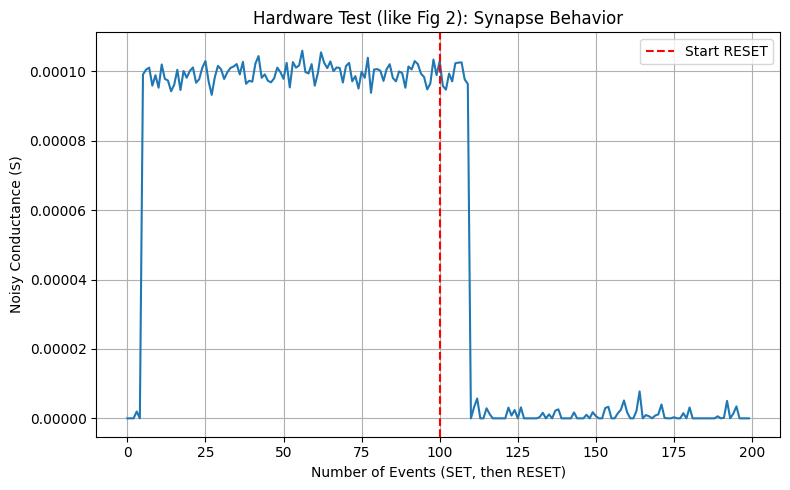


--- Running Network Simulation (Fig 3b) ---
Initializing 15x15 synapse grid...
Synapse grid created.
Running simulation for 50 episodes...
  Episode 10/50 complete.
  Episode 20/50 complete.
  Episode 30/50 complete.
  Episode 40/50 complete.
  Episode 50/50 complete.
Simulation finished.


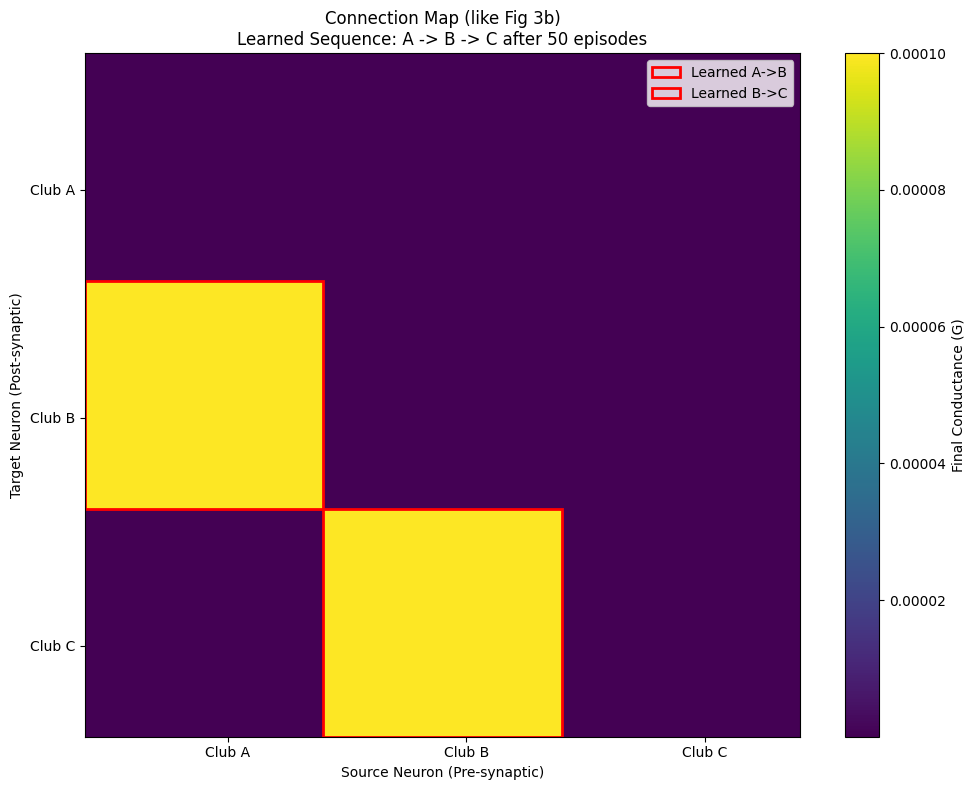

In [6]:
# --- Run the Main Program ---
if __name__ == "__main__":
    # 1. Show the single synapse behavior
    plot_hardware_test()

    # 2. Show the full network learning
    plot_network_test()